In [1]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
device = "cuda:4"
sd = 'runwayml/stable-diffusion-v1-5'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from diffusers import DDIMScheduler

from Freeprompt.diffuser_utils import FreePromptPipeline
from Freeprompt.freeprompt_utils import register_attention_control_new
from torchvision.utils import save_image
from torchvision.io import read_image
from Freeprompt.freeprompt import SelfAttentionControlEdit,AttentionStore


#### Model Construction

In [3]:
scheduler = DDIMScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
)
pipe = FreePromptPipeline.from_pretrained(sd, scheduler=scheduler).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/data1/junchao/miniconda3/envs/tie/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:221: FutureWarning: The configuration file of this scheduler: DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.31.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could op

#### Real editing

In [5]:
def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.0  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(device)
    return image


self_replace_steps = 0.8
NUM_DIFFUSION_STEPS = 50

out_dir = "../output/fpe"
# mkdir
os.makedirs(out_dir, exist_ok=True)

SOURCE_IMAGE_PATH = "../image/000141.jpg"
source_image = load_image(SOURCE_IMAGE_PATH, device)

source_prompt = ""

# invert the source image
start_code, latents_list = pipe.invert(
    source_image,
    source_prompt,
    guidance_scale=7.5,
    num_inference_steps=50,
    return_intermediates=True,
)

target_prompt = "a red car"

latents = torch.randn(start_code.shape, device=device)
prompts = [source_prompt, target_prompt]

start_code = start_code.expand(len(prompts), -1, -1, -1)
controller = SelfAttentionControlEdit(
    prompts, NUM_DIFFUSION_STEPS, self_replace_steps=self_replace_steps
)

register_attention_control_new(pipe, controller)

# Note: querying the inversion intermediate features latents_list
# may obtain better reconstruction and editing results
results = pipe(
    prompts,
    latents=start_code,
    guidance_scale=7.5,
    ref_intermediate_latents=latents_list,
)


save_image(results[1], os.path.join(out_dir, str(target_prompt) + ".jpg"))

DDIM Sampler: 100%|██████████| 50/50 [00:10<00:00,  5.00it/s]


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(tensor):
    tensor = tensor.cpu()
    image_list = [
        Image.fromarray((img.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        for img in tensor
    ]
    # 使用 matplotlib 显示图片
    plt.figure(figsize=(10, 5))
    for i, img in enumerate(image_list):
        plt.subplot(1, len(image_list), i + 1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

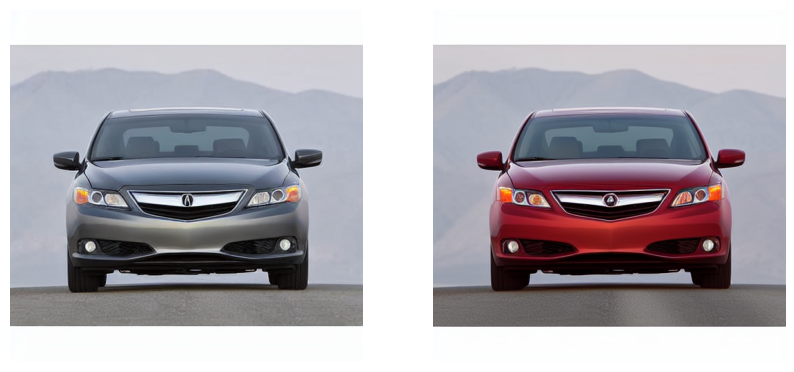

In [23]:
show_images(results)